In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

import tarfile
from six.moves import urllib

try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImpute
    
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from numpy import asarray,savetxt,loadtxt

In [3]:
# to make this notebook's output identical at every run
np.random.seed(42)

# Datasets disponíveis

In [4]:
# train_users.csv - the training set of users
pd.read_csv('train_users_2.csv').head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
# test_users.csv - the test set of users
# id: user id
# date_account_created: the date of account creation
# timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
# date_first_booking: date of first booking
# gender
# age
# signup_method
# signup_flow: the page a user came to signup up from
# language: international language preference
# affiliate_channel: what kind of paid marketing
# affiliate_provider: where the marketing is e.g. google, craigslist, other
# first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
# signup_app
# first_device_type
# first_browser
# country_destination: this is the target variable you are to predict
pd.read_csv('test_users.csv').head(5)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [6]:
# sessions.csv - web sessions log for users
# user_id: to be joined with the column 'id' in users table
# action
# action_type
# action_detail
# device_type
# secs_elapsed
pd.read_csv('sessions.csv').head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [7]:
# countries.csv - summary statistics of destination countries in this dataset and their locations
pd.read_csv('countries.csv')

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


In [8]:
# age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination
pd.read_csv('age_gender_bkts.csv')

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0
...,...,...,...,...,...
415,95-99,US,male,115.0,2015.0
416,90-94,US,male,541.0,2015.0
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0


# Data visualization

In [9]:
data_train = pd.read_csv('train_users_2.csv')
data_train

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,NDF
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,NDF


In [10]:
data_train.describe()

,timestamp_first_active,age,signup_flow
count,2.134510e+05,125461.000000,213451.000000
mean,2.013085e+13,49.668335,3.267387
std,9.253717e+09,155.666612,7.637707
min,2.009032e+13,1.000000,0.000000
25%,2.012123e+13,28.000000,0.000000
50%,2.013091e+13,34.000000,0.000000
75%,2.014031e+13,43.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


<AxesSubplot:>

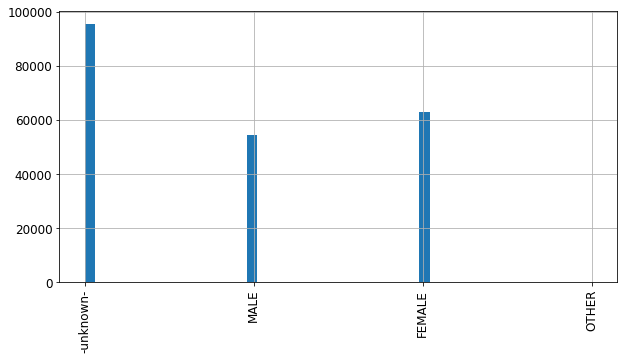

In [11]:
data_train['gender'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

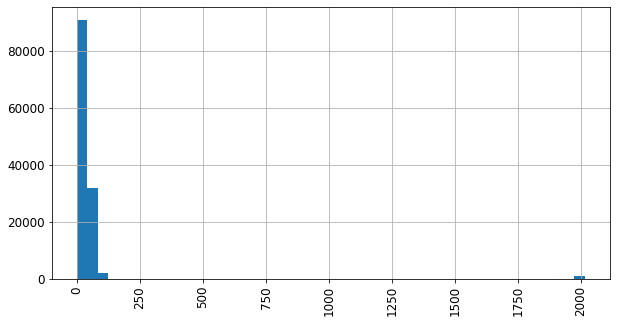

In [12]:
data_train['age'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

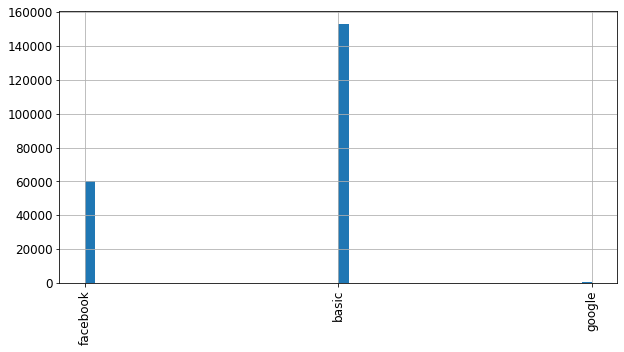

In [13]:
data_train['signup_method'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

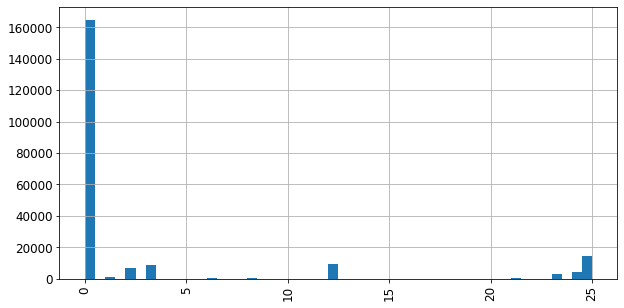

In [14]:
data_train['signup_flow'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

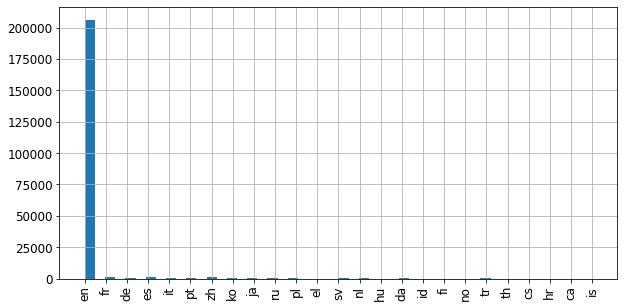

In [15]:
data_train['language'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

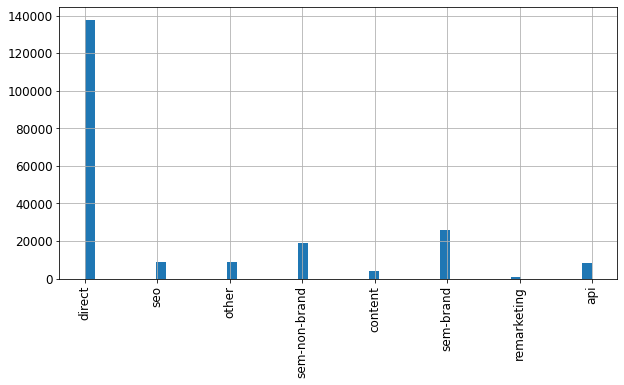

In [16]:
data_train['affiliate_channel'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

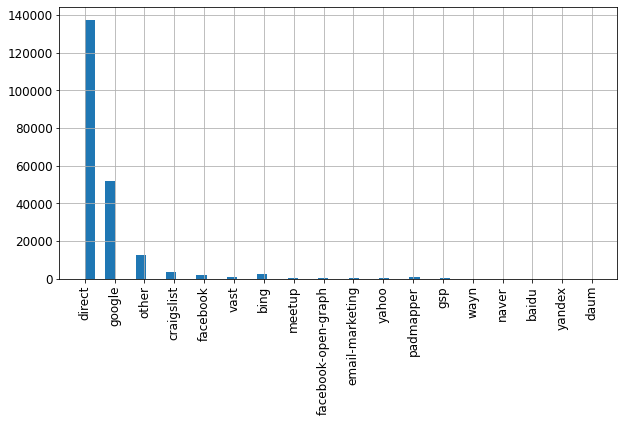

In [17]:
data_train['affiliate_provider'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

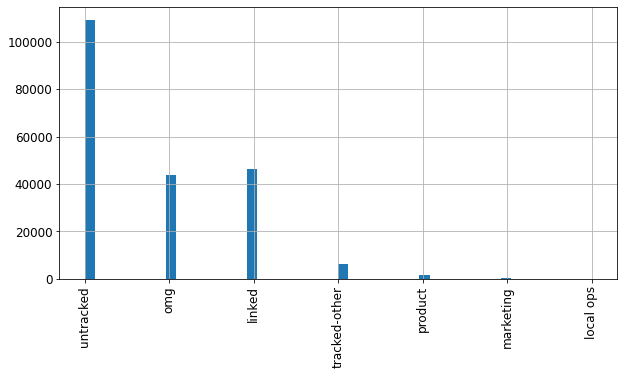

In [18]:
data_train['first_affiliate_tracked'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

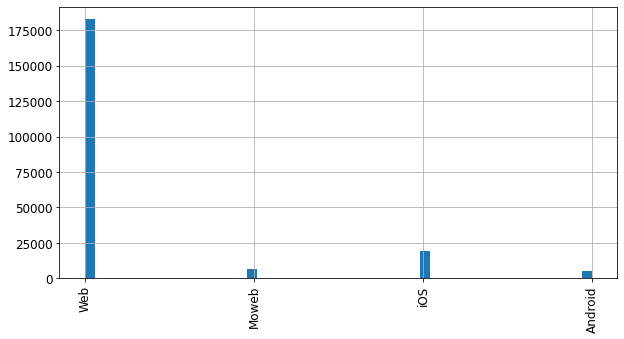

In [19]:
data_train['signup_app'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

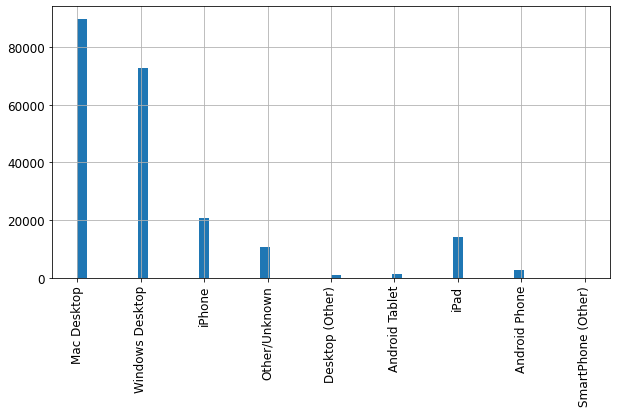

In [20]:
data_train['first_device_type'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

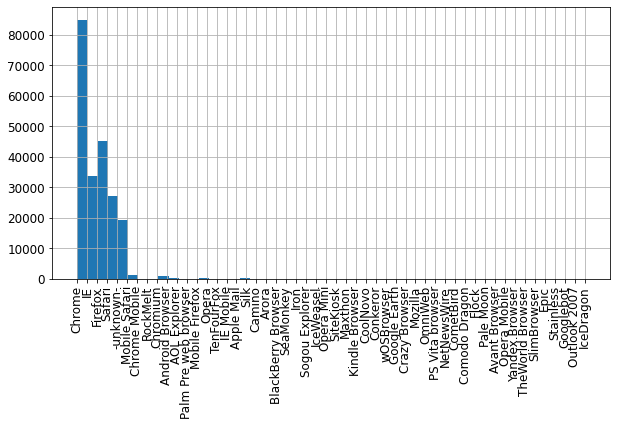

In [21]:
data_train['first_browser'].hist(bins=50, figsize=(10,5), xrot = 90)

<AxesSubplot:>

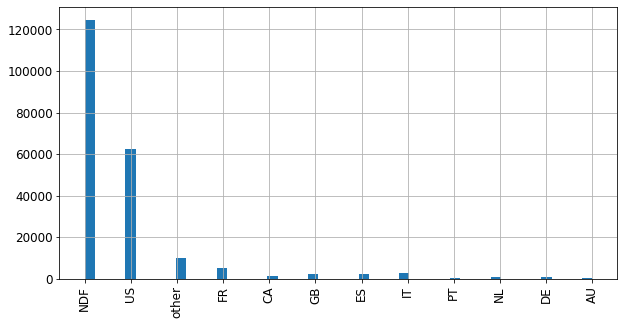

In [22]:
data_train['country_destination'].hist(bins=50, figsize=(10,5), xrot = 90)

**Verificando que a idade não é um dado tão confiável**

In [23]:
len(data_train[data_train['age'] > 100])

2345

**Verificando que há muitos usuários no dataset de treino que não possuem um país de destino definido**

<AxesSubplot:>

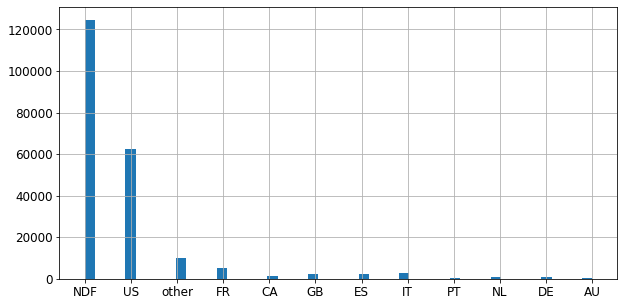

In [24]:
data_train['country_destination'].hist(bins=50, figsize=(10,5))

**Um insight que pode ser útil é que pode existir correlação entre o páis de destino da viagem e e língua preferida**

**Além disso pode ser útil tentar relacionar a idade do usuário e a idade do país de destino**

----

# Preparando os dados

Utilizando o dataset sessions.csv para obter informações de acesso dos usuários

In [25]:
p = pd.read_csv('sessions.csv')
p = p[p['action'].isin(['search_results', 'accept_decline', 'other_hosting_reviews_first', 'hosting_social_proof',
                   'decision_tree', 'recent_reservations', 'faq_experiment_ids', 'populate_from_facebook', 'south-america'
                    ,'my_reservations', 'report', 'agree_terms_check', 'read_policy_click','top_destinations', 
                    'create_airbnb', 'handle_vanity_url', 'impressions', 'message_to_host_focus','guest_booked_elsewhere',
                    'about_us', 'founders','travel_plans_previous', 'why_host', 'hospitality_standards','photography_update'
                    , 'badge', 'apply', 'redirect', 'pricing','apply_code', 'slideshow', 'locations','authenticate', 'calendar_tab_inner2', 
                    'other_hosting_reviews','social_connections', 'relationship','collections', 'pending', 'at_checkpoint', 'booking'])]
## Calculando o tempo total por user
aux_1 = p[['user_id', 'secs_elapsed']].groupby(by=["user_id"]).sum()
aux_1['user_id'] = aux_1.index
aux_1.reset_index(drop=True, inplace=True)
## Calculando a quantidade de acessos por user
aux_2 = p.groupby(by=["user_id"]).count()
aux_2['user_id'] = aux_2.index
aux_2 = aux_2[['user_id', 'action']].reset_index(drop=True)
users_access = aux_1.merge(aux_2, left_on='user_id', right_on='user_id')
users_access = users_access.rename(columns={"action": "actions", "user_id": "id"})
users_access

,secs_elapsed,id,actions
0,22079.0,00023iyk9l,2
1,45844.0,0010k6l0om,8
2,33917.0,001wyh0pz8,6
3,158183.0,002qnbzfs5,73
4,0.0,0031awlkjq,1
...,...,...,...
104853,216976.0,zzx5wp3lqu,23
104854,129579.0,zzxox7jnrx,13
104855,1533.0,zzysuoqg6x,1
104856,545256.0,zzywmcn0jv,3


In [26]:
len(p['user_id'].unique())

104859

In [27]:
len(data_train['id'].unique())

213451

In [28]:
contry_labels = data_train["country_destination"].copy()
data_train_split = data_train.drop("country_destination", axis=1) # drop labels for training set

In [29]:
## Setando o identificador do usuário como índice
data_train_split = data_train_split.set_index('id')

**A partir desse ponto o tratamento dos dados deve ser feito em: `data_train_split`**

In [30]:
data_train_split.head(5)

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,,
gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [31]:
data_train[data_train['first_affiliate_tracked'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
12,k6np330cm1,2010-01-05,20100105060859,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,FR
16,2dwbwkx056,2010-01-07,20100107215125,NaN,-unknown-,NaN,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,NDF
17,frhre329au,2010-01-07,20100107224625,2010-01-09,-unknown-,31.0,basic,0,en,other,craigslist,NaN,Web,Other/Unknown,-unknown-,US
18,cxlg85pg1r,2010-01-08,20100108015641,NaN,-unknown-,NaN,basic,0,en,seo,facebook,NaN,Web,Other/Unknown,-unknown-,NDF
20,qdubonn3uk,2010-01-10,20100110152120,2010-01-18,-unknown-,NaN,basic,0,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197868,c1qplgehvg,2014-06-01,20140601141744,NaN,-unknown-,NaN,basic,25,en,direct,direct,NaN,iOS,Other/Unknown,-unknown-,NDF
200289,us5b8o8joz,2014-06-05,20140605220222,NaN,-unknown-,NaN,basic,25,en,direct,direct,NaN,iOS,Other/Unknown,-unknown-,NDF
203847,202t9mxmon,2014-06-12,20140612235741,NaN,-unknown-,NaN,basic,25,en,direct,direct,NaN,iOS,Other/Unknown,-unknown-,NDF
206913,9osh0ra0i9,2014-06-19,20140619022617,NaN,-unknown-,NaN,basic,25,en,direct,direct,NaN,iOS,Other/Unknown,-unknown-,NDF


### Colunas que possuem valores NaN:

In [32]:
for column in data_train_split.columns:
    if len(data_train_split[data_train_split[column].isnull()]) != 0:
        print(column)

date_first_booking
age
first_affiliate_tracked


##### Exluindo data de primeira compra do dataset, pois logicamente não há esse tipo de informação no conjunto de teste

In [33]:
data_train_split = data_train_split.drop(['date_first_booking'], axis=1)

#### Transformando dados em formato de data para formato numérico

In [34]:
data_train_split

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,
gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxodksqpep,2014-06-30,20140630235636,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
mhewnxesx9,2014-06-30,20140630235719,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
6o3arsjbb4,2014-06-30,20140630235754,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox


In [35]:
data_train_split['date_account_created'] = pd.to_numeric(data_train_split['date_account_created'].str.replace('-',''))
data_train_split

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,
gxn3p5htnn,20100628,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,20110525,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,20100928,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,20111205,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,20100914,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zxodksqpep,20140630,20140630235636,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
mhewnxesx9,20140630,20140630235719,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
6o3arsjbb4,20140630,20140630235754,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox


#### Preenchendo NaN em 'first_affiliate_tracked' com o mais frequente

In [36]:
data_train_split_fatr = data_train_split[['first_affiliate_tracked']]
data_train_split_fatr
imputer_freq = SimpleImputer(strategy="most_frequent")
imputer_freq.fit(data_train_split_fatr)
X = imputer_freq.transform(data_train_split_fatr)
data_train_split['first_affiliate_tracked'] = X

In [37]:
# check
data_train_split[data_train_split['first_affiliate_tracked'].isnull()]

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,,,,,


#### Preenchendo os dados numéricos NaN com as respectivas medianas desses atributos

In [38]:
# Selecionando atributos que já são numéricos
data_train_split_num = data_train_split.select_dtypes(include=[np.number])
data_train_split_num

,date_account_created,timestamp_first_active,age,signup_flow
id,,,,
gxn3p5htnn,20100628,20090319043255,NaN,0
820tgsjxq7,20110525,20090523174809,38.0,0
4ft3gnwmtx,20100928,20090609231247,56.0,3
bjjt8pjhuk,20111205,20091031060129,42.0,0
87mebub9p4,20100914,20091208061105,41.0,0
...,...,...,...,...
zxodksqpep,20140630,20140630235636,32.0,0
mhewnxesx9,20140630,20140630235719,NaN,0
6o3arsjbb4,20140630,20140630235754,32.0,0


In [39]:
imputer = SimpleImputer(strategy="median")
imputer.fit(data_train_split_num)
X = imputer.transform(data_train_split_num)
# X
data_train_split_num_tr = pd.DataFrame(X, columns=data_train_split_num.columns,
                          index=data_train_split_num.index)
data_train_split_num_tr

,date_account_created,timestamp_first_active,age,signup_flow
id,,,,
gxn3p5htnn,20100628.0,2.009032e+13,34.0,0.0
820tgsjxq7,20110525.0,2.009052e+13,38.0,0.0
4ft3gnwmtx,20100928.0,2.009061e+13,56.0,3.0
bjjt8pjhuk,20111205.0,2.009103e+13,42.0,0.0
87mebub9p4,20100914.0,2.009121e+13,41.0,0.0
...,...,...,...,...
zxodksqpep,20140630.0,2.014063e+13,32.0,0.0
mhewnxesx9,20140630.0,2.014063e+13,34.0,0.0
6o3arsjbb4,20140630.0,2.014063e+13,32.0,0.0


In [40]:
data_train_split_attr = data_train_split.drop(list(data_train_split_num.columns), axis=1)
data_train_split_attr

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
id,,,,,,,,,
gxn3p5htnn,-unknown-,facebook,en,direct,direct,untracked,Web,Mac Desktop,Chrome
820tgsjxq7,MALE,facebook,en,seo,google,untracked,Web,Mac Desktop,Chrome
4ft3gnwmtx,FEMALE,basic,en,direct,direct,untracked,Web,Windows Desktop,IE
bjjt8pjhuk,FEMALE,facebook,en,direct,direct,untracked,Web,Mac Desktop,Firefox
87mebub9p4,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome
...,...,...,...,...,...,...,...,...,...
zxodksqpep,MALE,basic,en,sem-brand,google,omg,Web,Mac Desktop,Safari
mhewnxesx9,-unknown-,basic,en,direct,direct,linked,Web,Windows Desktop,Chrome
6o3arsjbb4,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Firefox


In [41]:
ordinal_encoder = OrdinalEncoder()
data_train_split_attr_enc = ordinal_encoder.fit_transform(data_train_split_attr)
data_train_split_attr_enc

array([[ 0.,  1.,  5., ...,  2.,  3.,  8.],
       [ 2.,  1.,  5., ...,  2.,  3.,  8.],
       [ 1.,  0.,  5., ...,  2.,  6., 21.],
       ...,
       [ 0.,  0.,  5., ...,  2.,  3., 17.],
       [ 0.,  0.,  5., ...,  3.,  8., 29.],
       [ 0.,  0.,  5., ...,  3.,  8.,  0.]])

Vê-se que o OrdinalEncoder atribui uma numeração para cada atributo de acordo com a ordem alfabética

In [42]:
ordinal_encoder.categories_

[array(['-unknown-', 'FEMALE', 'MALE', 'OTHER'], dtype=object),
 array(['basic', 'facebook', 'google'], dtype=object),
 array(['ca', 'cs', 'da', 'de', 'el', 'en', 'es', 'fi', 'fr', 'hr', 'hu',
        'id', 'is', 'it', 'ja', 'ko', 'nl', 'no', 'pl', 'pt', 'ru', 'sv',
        'th', 'tr', 'zh'], dtype=object),
 array(['api', 'content', 'direct', 'other', 'remarketing', 'sem-brand',
        'sem-non-brand', 'seo'], dtype=object),
 array(['baidu', 'bing', 'craigslist', 'daum', 'direct', 'email-marketing',
        'facebook', 'facebook-open-graph', 'google', 'gsp', 'meetup',
        'naver', 'other', 'padmapper', 'vast', 'wayn', 'yahoo', 'yandex'],
       dtype=object),
 array(['linked', 'local ops', 'marketing', 'omg', 'product',
        'tracked-other', 'untracked'], dtype=object),
 array(['Android', 'Moweb', 'Web', 'iOS'], dtype=object),
 array(['Android Phone', 'Android Tablet', 'Desktop (Other)',
        'Mac Desktop', 'Other/Unknown', 'SmartPhone (Other)',
        'Windows Desktop', 'i

In [43]:
cat_encoder = OneHotEncoder()
data_train_split_attr_1henc = cat_encoder.fit_transform(data_train_split_attr)
data_train_split_attr_1henc

<213451x130 sparse matrix of type '<class 'numpy.float64'>'
	with 1921059 stored elements in Compressed Sparse Row format>

In [44]:
data_train_split_attr_1henc.toarray()[0]

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
data_train_split_attr_1henc.toarray()[1]

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [46]:
cat_encoder.categories_

[array(['-unknown-', 'FEMALE', 'MALE', 'OTHER'], dtype=object),
 array(['basic', 'facebook', 'google'], dtype=object),
 array(['ca', 'cs', 'da', 'de', 'el', 'en', 'es', 'fi', 'fr', 'hr', 'hu',
        'id', 'is', 'it', 'ja', 'ko', 'nl', 'no', 'pl', 'pt', 'ru', 'sv',
        'th', 'tr', 'zh'], dtype=object),
 array(['api', 'content', 'direct', 'other', 'remarketing', 'sem-brand',
        'sem-non-brand', 'seo'], dtype=object),
 array(['baidu', 'bing', 'craigslist', 'daum', 'direct', 'email-marketing',
        'facebook', 'facebook-open-graph', 'google', 'gsp', 'meetup',
        'naver', 'other', 'padmapper', 'vast', 'wayn', 'yahoo', 'yandex'],
       dtype=object),
 array(['linked', 'local ops', 'marketing', 'omg', 'product',
        'tracked-other', 'untracked'], dtype=object),
 array(['Android', 'Moweb', 'Web', 'iOS'], dtype=object),
 array(['Android Phone', 'Android Tablet', 'Desktop (Other)',
        'Mac Desktop', 'Other/Unknown', 'SmartPhone (Other)',
        'Windows Desktop', 'i

In [47]:
users_access

,secs_elapsed,id,actions
0,22079.0,00023iyk9l,2
1,45844.0,0010k6l0om,8
2,33917.0,001wyh0pz8,6
3,158183.0,002qnbzfs5,73
4,0.0,0031awlkjq,1
...,...,...,...
104853,216976.0,zzx5wp3lqu,23
104854,129579.0,zzxox7jnrx,13
104855,1533.0,zzysuoqg6x,1
104856,545256.0,zzywmcn0jv,3


In [48]:
teste_concat = data_train.drop("country_destination", axis=1)
teste_concat

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari


In [49]:
teste_concat.join(users_access.set_index('id'), on='id')

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,secs_elapsed,actions
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NaN,NaN
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN,NaN
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NaN,NaN
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,zxodksqpep,2014-06-30,20140630235636,NaN,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,2102433.0,16.0
213447,mhewnxesx9,2014-06-30,20140630235719,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,1029676.0,25.0
213448,6o3arsjbb4,2014-06-30,20140630235754,NaN,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,15708.0,2.0
213449,jh95kwisub,2014-06-30,20140630235822,NaN,-unknown-,NaN,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,23245.0,5.0


In [50]:
users_access.head(5)

,secs_elapsed,id,actions
0,22079.0,00023iyk9l,2
1,45844.0,0010k6l0om,8
2,33917.0,001wyh0pz8,6
3,158183.0,002qnbzfs5,73
4,0.0,0031awlkjq,1


## Organizando o pipeline de processamento

In [51]:
def aux_process(data):
    # Concatenando dataset principal com dados de acessos dos usuários
    data = data.join(users_access.set_index('id'), on='id')
    
    # Setando id do usuário como índice
    data = data.set_index('id')
    
    # Removendo coluna de data de primeira reserva
    data = data.drop(['date_first_booking'], axis=1)
    
    # Transformando data de criação de conta em numérica
    data['date_account_created'] = pd.to_numeric(data['date_account_created'].str.replace('-',''))
    
    # Atribuindo a data de 'first_affiliate' ao NaN como o mais frequente
    data_train_split_fatr = data[['first_affiliate_tracked']]
    imputer_freq = SimpleImputer(strategy="most_frequent")
    imputer_freq.fit(data_train_split_fatr)
    X = imputer_freq.transform(data_train_split_fatr)
    data['first_affiliate_tracked'] = X
        
    return data

In [52]:
data_train_pre_processing = aux_process(data_train.drop("country_destination", axis=1))

In [53]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler())
    ])

# data_train_split_num_tr = num_pipeline.fit_transform(data_train_split_num) -> Para teste

In [54]:
num_attribs = list(data_train_pre_processing.select_dtypes(include=[np.number]))
cat_attribs = [x for x in list(data_train_pre_processing) if x not in num_attribs]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
        ,("cat", OneHotEncoder(), cat_attribs)
#         ,("cat", OrdinalEncoder(), cat_attribs)
    ])

##### Processando e salvando conjunto de dados:

In [55]:
# lembrando que data_train_split = data_train.drop("country_destination", axis=1) # drop labels for training set
reservation_data_prepared = full_pipeline.fit_transform(data_train_pre_processing)
if type(reservation_data_prepared) is np.ndarray:
    data_train_prep = reservation_data_prepared
else:
    data_train_prep = reservation_data_prepared.toarray()

In [56]:
data_train_prep[0]

array([-3.2686404 , -4.38002036, -0.07700686, -0.42779785, -0.18230397,
       -0.15844674,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [57]:
savetxt('data_train_prepared.csv', data_train_prep, delimiter=';')

In [58]:
data_test = pd.read_csv('test_users.csv')
data_test_pre_processing = aux_process(data_test)

In [59]:
reservation_data_prepared_t = full_pipeline.fit_transform(data_test_pre_processing)
if type(reservation_data_prepared_t) is np.ndarray:
    data_test_prep = reservation_data_prepared_t
else:
    data_test_prep = reservation_data_prepared_t.toarray()

In [60]:
data_test_prep[0]

array([-1.37780762, -1.37933737,  0.00843724, -0.69430835, -0.59924505,
       -0.54937901,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.  

In [61]:
savetxt('data_test_prepared.csv', data_test_prep, delimiter=';')